### **NOTE**

The following code was **adopted from the TensorFlow implementation** of LOCALS to enable the development of **LOCALS-Multi** (multiple LaSOs per image).
LOCALS-Multi retrains a model originally trained with **LOCALS-Single** (single LaSO per image) to achieve improved performance.

Due to this inheritance from the TensorFlow implementation, the **dataset format** used in LOCALS-Single follows the TensorFlow convention:

$$
\textbf{TensorFlow format: } [\text{Batch (B)}, \text{Height (H)}, \text{Width (W)}, \text{Channels (C)}]
$$

However, PyTorch uses a different convention:

$$
\textbf{PyTorch format: } [\text{Batch (B)}, \text{Channels (C)}, \text{Height (H)}, \text{Width (W)}]
$$

As a result, the code includes the use of **`torch.permute()`** to **rearrange tensor dimensions** and ensure compatibility with PyTorch’s expected input format.

```python
# Example: Convert from NHWC (TensorFlow) to NCHW (PyTorch)
inputs = inputs.permute(0, 3, 1, 2)  # (B, H, W, C) → (B, C, H, W)
```

This conversion is **crucial for proper model training and inference** within the PyTorch framework.


# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pickle
from typing import List, Tuple
import numpy as np
import random

In [2]:
batch_size = 1

# Model

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.model = nn.Sequential(
            # first block
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.LayerNorm([64, 240, 240]),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # second block
            nn.Conv2d(64, 192, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([192, 60, 60]),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # third block
            nn.Conv2d(192, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([256, 30, 30]),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([512, 30, 30]),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # fourth block
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([512, 15, 15]),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([1024, 8, 8]),

            # final block
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([1024, 4, 4])
        )

        # manually initialize all Conv2d layers' weights with He Normal (Kaiming Normal)
        for m in self.model:
            if isinstance(m, nn.Conv2d): # if layer is a conv layer
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # initialize weights with He Normal
                if m.bias is not None: # initialize bias with zeros
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)

In [4]:
class ProtoModel(nn.Module):
    def __init__(self):
        super(ProtoModel, self).__init__()
        self.feature_extractor = FeatureExtractor()  # from earlier
        
        # the output from the extractor is [batch, 1024, 4, 4], flatten it
        self.flatten = nn.Flatten()

        # dense layer, output shape is [batch, 147]
        self.fc = nn.Linear(in_features=1024 * 4 * 4, out_features=7 * 7 * 3)

        # sigmoid activation for output normalization
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.feature_extractor(x)             # [batch, 1024, 4, 4]
        x = self.flatten(x)                       # [batch, 1024*4*4]
        x = self.fc(x)                            # [batch, 147]
        x = self.activation(x)                    # [batch, 147]
        x = x.view(-1, 3, 7, 7)                   # Reshape to [batch, 3, 7, 7]
        x = x.permute(0, 2, 3, 1)                 # change to [batch, 7, 7, 3]
        return x

# Loss Function

In [24]:
def locals_loss(alpha=1.0, beta=5.0, gamma=5.0):  
    '''
    alpha: weight for correlation loss
    beta: weight for localization loss
    gamma: weight for objectness loss
    '''

    # initialize binary cross entropy
    bce = nn.BCELoss(reduction='none')

    # calculates pearson correlation to only points filtered out by a mask
    def pearson_corr_mask(a, b, mask):
        a = a * mask
        b = b * mask

        mask_sum = torch.sum(mask) + 1e-8
        mean_a = torch.sum(a) / mask_sum
        mean_b = torch.sum(b) / mask_sum

        num = torch.sum((a - mean_a) * (b - mean_b) * mask)
        denom = torch.sqrt(torch.sum((a - mean_a)**2 * mask)) * torch.sqrt(torch.sum((b - mean_b)**2 * mask))
        return num / (denom + 1e-8)

    # actual loss function
    def loss_func(predicted, true):
        # goal is to sum each loss for each prediction in each batch
        loc_loss = 0
        obj_loss = 0
        corr_loss = 0
        
        # iterate through each image in the batch
        for i in range(batch_size):
            ith_predicted = predicted[i]
            ith_true = true[i]

            x_true = ith_true[..., 0]
            y_true = ith_true[..., 1]
            obj_mask = ith_true[..., 2]

            x_pred = ith_predicted[..., 0]
            y_pred = ith_predicted[..., 1]
            obj_pred = ith_predicted[..., 2]

            # find localization loss
            loc_loss_x = (x_true - x_pred)**2 * obj_mask
            loc_loss_y = (y_true - y_pred)**2 * obj_mask
            loc_loss += torch.sum(loc_loss_x) + torch.sum(loc_loss_y)

            # find objectness loss
            ith_obj_loss = bce(obj_pred, obj_mask)
            ith_obj_loss = torch.sum(ith_obj_loss) / (torch.sum(obj_mask) + 1e-8)
            obj_loss += ith_obj_loss

            # find correlation loss
            corr_true = pearson_corr_mask(x_true, y_true, obj_mask)
            corr_pred = pearson_corr_mask(x_pred, y_pred, obj_mask)
            corr_loss += torch.abs(corr_true - corr_pred)

        # first find mean loss
        loc_loss /= batch_size
        obj_loss /= batch_size
        corr_loss /= batch_size

        # then find total loss
        total_loss = beta * loc_loss + gamma * obj_loss + alpha * corr_loss
        return total_loss

    return loss_func

# Dataset

In [42]:
with open(r"LOCALS-Single-PKL-DATASET.pkl", "rb") as f:
    data = pickle.load(f)

In [7]:
class PKLDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y

In [8]:
dataset = PKLDataset(data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [9]:
for x_batch, y_batch in dataloader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([1, 480, 480, 3]) torch.Size([1, 7, 7, 3])


Dataset Partitioning

In [10]:
# constants
DATASET_SIZE = len(dataset)  # Should be 499
TRAIN_RATIO = 0.9
TEST_RATIO = 0.05
VAL_RATIO = 0.05

# lengths of splits
train_len = int(TRAIN_RATIO * DATASET_SIZE)
test_len = int(TEST_RATIO * DATASET_SIZE)
val_len = DATASET_SIZE - train_len - test_len  # ensures total adds up

torch.manual_seed(196)
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_len, test_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

449
24
26


# Dataset Visualization

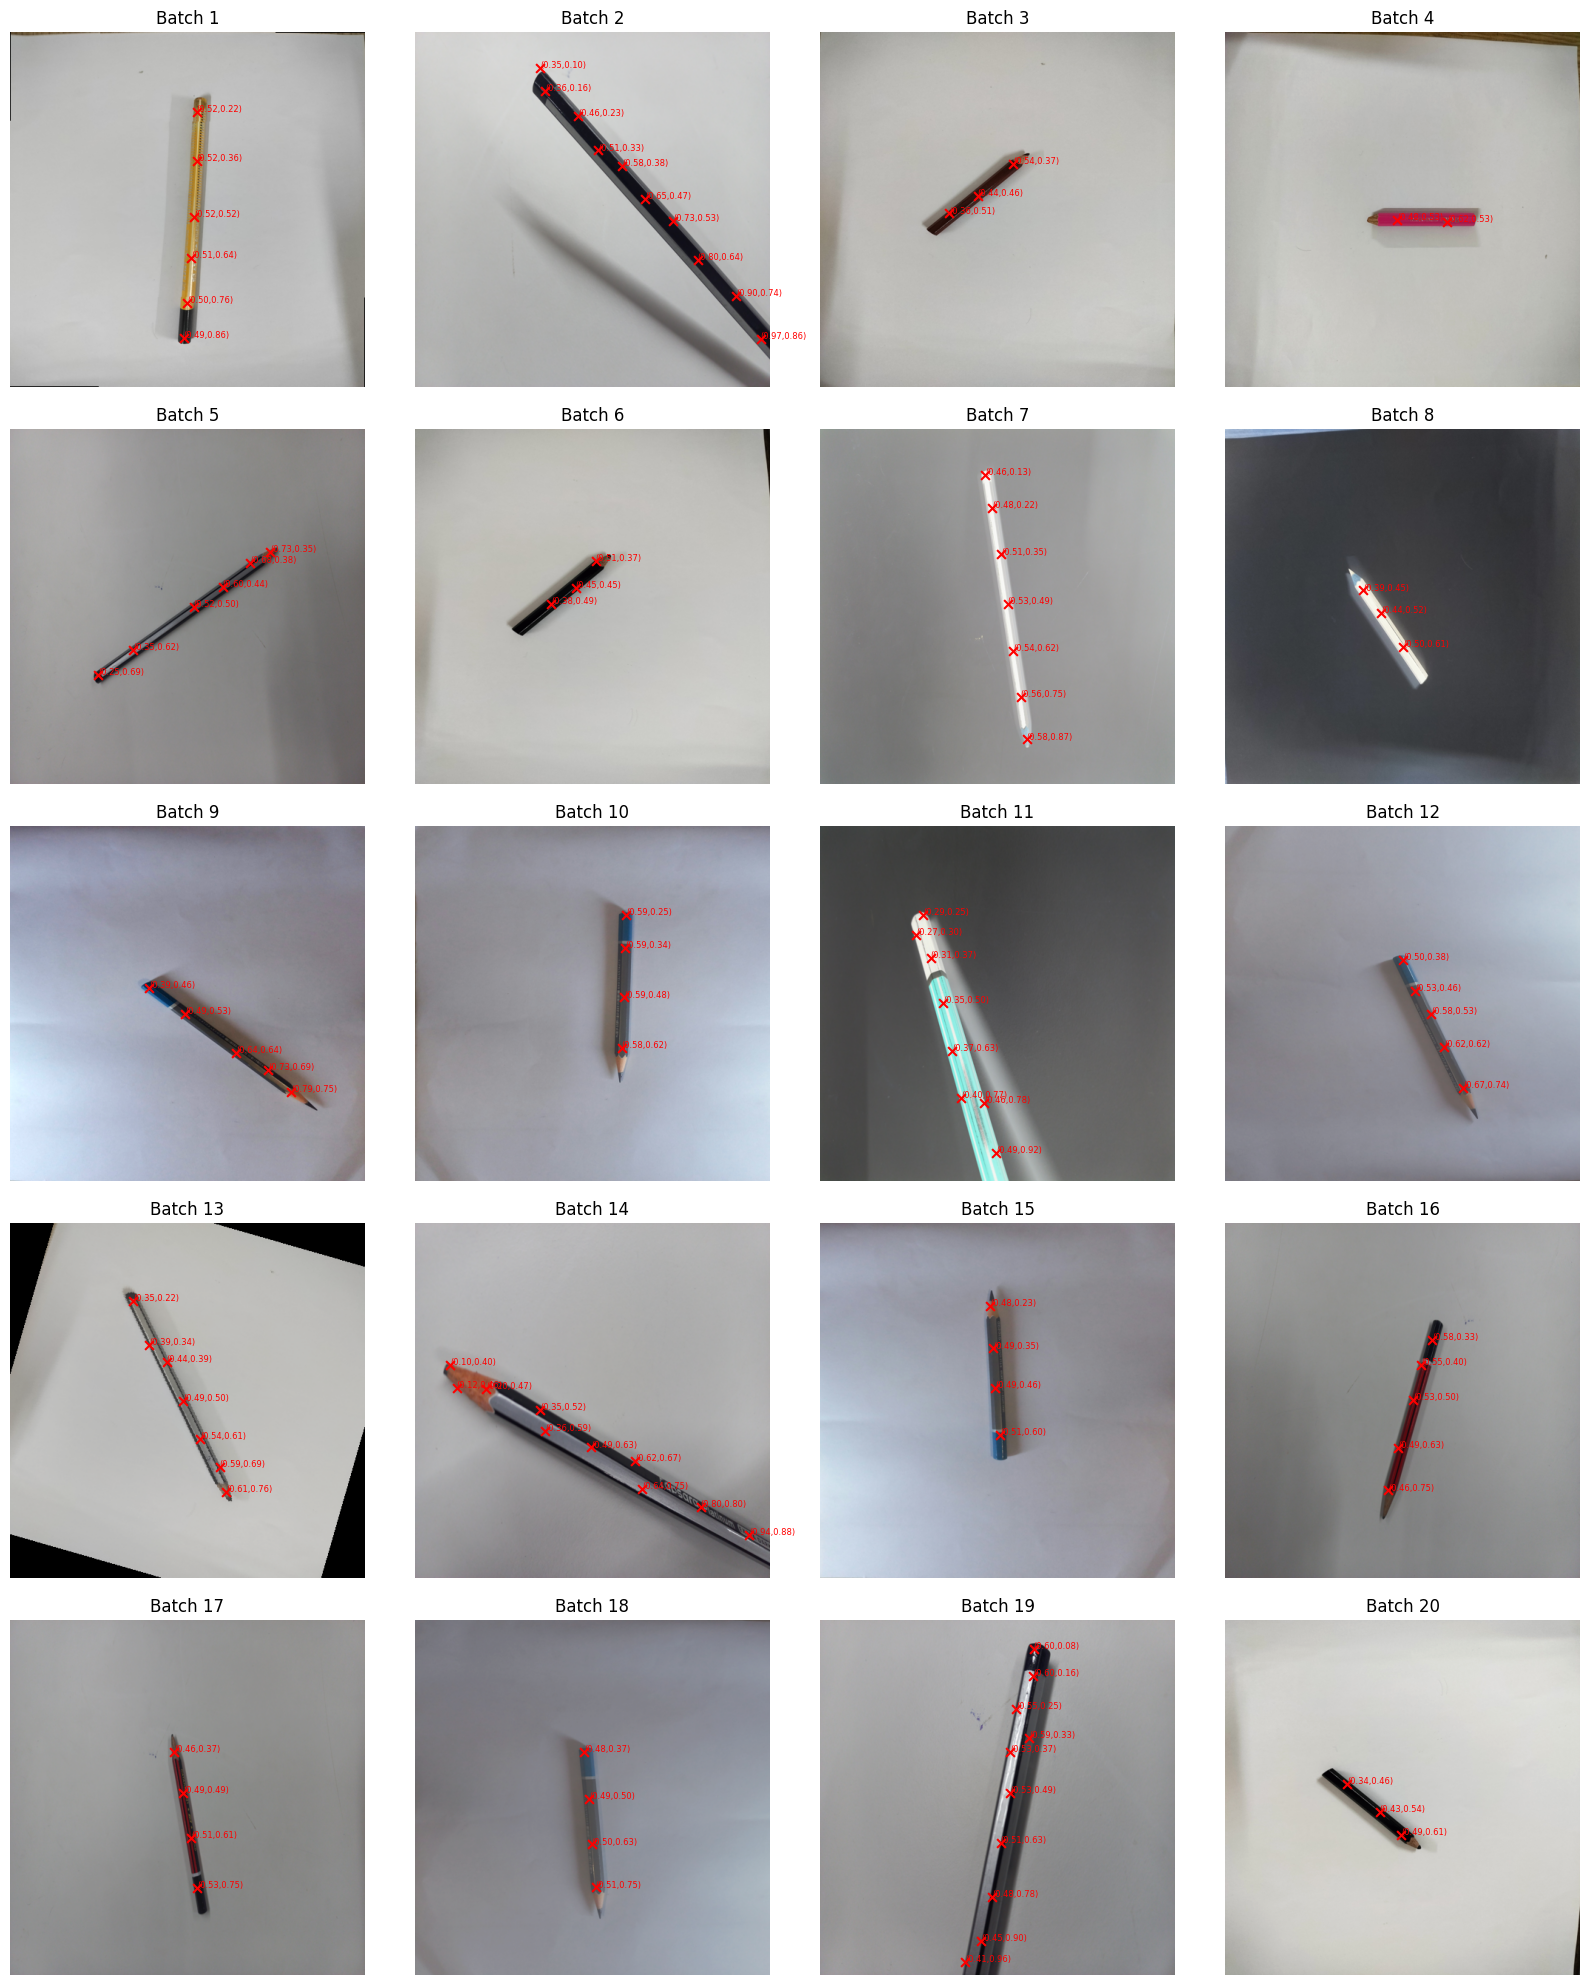

In [11]:
def visualize_dataset(dataloader, num_batches=20, grid_rows=5, grid_cols=4):
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
    axes = axes.flatten()

    batch_iter = iter(dataloader)

    for batch_idx in range(min(num_batches, len(axes))):
        try:
            image, label = next(batch_iter)
        except StopIteration:
            break  # in case dataloader has fewer than num_batches

        image_np = image[0].numpy()  # (1, 480, 480, 3) -> (480, 480, 3)
        label_np = label[0].numpy()  # (1, 7, 7, 3) -> (7, 7, 3)

        # if image is normalized
        if image_np.max() <= 1.0:
            # denormalize image
            image_np = (image_np * 255).astype(np.uint8)

        img_height, img_width = image_np.shape[:2]
        ax = axes[batch_idx]
        ax.axis('off')

        if image_np.ndim == 2:
            ax.imshow(image_np, cmap='gray')
        else:
            ax.imshow(image_np)

        for row in range(7):
            for col in range(7):
                x, y, obj = label_np[row, col]
                if obj == 1:
                    x_coord = x * img_width
                    y_coord = y * img_height
                    ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                    ax.text(x_coord, y_coord, f"({x:.2f},{y:.2f})", fontsize=6, color='red')

        ax.set_title(f"Batch {batch_idx + 1}")

    # turn off unused axes
    for i in range(batch_idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_dataset(dataloader)

# Training

In [12]:
# model, optimizer, and custom loss
device = 'cuda'
model = ProtoModel()
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = locals_loss()

# training parameters
num_epochs = 100
loss_ot = [] # loss overtime

In [13]:
for epoch in range(num_epochs):
    # training on training dataset
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, targets in pbar:
        inputs = inputs.to(device).permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Avg Training Loss = {avg_loss}")
    loss_ot.append(avg_loss)

    # evaluating on validation dataset
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device).permute(0, 3, 1, 2)
            val_targets = val_targets.to(device)

            val_outputs = model(val_inputs)
            loss= criterion(val_outputs, val_targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Avg Validation Loss = {avg_val_loss}")

Epoch 1/100: 100%|██████████| 449/449 [00:13<00:00, 32.15it/s]


Epoch 1: Avg Training Loss = 12.670418992074401
Epoch 1: Avg Validation Loss = 10.478306495226347


Epoch 2/100: 100%|██████████| 449/449 [00:13<00:00, 33.16it/s]


Epoch 2: Avg Training Loss = 7.405460316248089
Epoch 2: Avg Validation Loss = 5.625475535025964


Epoch 3/100: 100%|██████████| 449/449 [00:13<00:00, 33.12it/s]


Epoch 3: Avg Training Loss = 4.243407514419216
Epoch 3: Avg Validation Loss = 4.441328310049498


Epoch 4/100: 100%|██████████| 449/449 [00:13<00:00, 33.17it/s]


Epoch 4: Avg Training Loss = 3.2729501004739436
Epoch 4: Avg Validation Loss = 3.800494874899204


Epoch 5/100: 100%|██████████| 449/449 [00:13<00:00, 33.18it/s]


Epoch 5: Avg Training Loss = 2.603947593002914
Epoch 5: Avg Validation Loss = 3.361452490091324


Epoch 6/100: 100%|██████████| 449/449 [00:13<00:00, 33.18it/s]


Epoch 6: Avg Training Loss = 2.2390736204744184
Epoch 6: Avg Validation Loss = 3.2238508600455065


Epoch 7/100: 100%|██████████| 449/449 [00:13<00:00, 33.27it/s]


Epoch 7: Avg Training Loss = 2.1230657279889673
Epoch 7: Avg Validation Loss = 3.0200630678580356


Epoch 8/100: 100%|██████████| 449/449 [00:13<00:00, 33.29it/s]


Epoch 8: Avg Training Loss = 1.83825268093621
Epoch 8: Avg Validation Loss = 3.0816638377996592


Epoch 9/100: 100%|██████████| 449/449 [00:13<00:00, 33.27it/s]


Epoch 9: Avg Training Loss = 1.6774806389564396
Epoch 9: Avg Validation Loss = 2.8438842479999247


Epoch 10/100: 100%|██████████| 449/449 [00:13<00:00, 33.29it/s]


Epoch 10: Avg Training Loss = 1.5826120018826295
Epoch 10: Avg Validation Loss = 2.7096936450554776


Epoch 11/100: 100%|██████████| 449/449 [00:13<00:00, 33.25it/s]


Epoch 11: Avg Training Loss = 1.4998354863350534
Epoch 11: Avg Validation Loss = 2.6276738964594326


Epoch 12/100: 100%|██████████| 449/449 [00:13<00:00, 33.23it/s]


Epoch 12: Avg Training Loss = 1.3708690150676166
Epoch 12: Avg Validation Loss = 2.5899571891014395


Epoch 13/100: 100%|██████████| 449/449 [00:13<00:00, 33.12it/s]


Epoch 13: Avg Training Loss = 1.341581886754535
Epoch 13: Avg Validation Loss = 2.5393525751737447


Epoch 14/100: 100%|██████████| 449/449 [00:13<00:00, 33.11it/s]


Epoch 14: Avg Training Loss = 1.2571724306435257
Epoch 14: Avg Validation Loss = 2.588987274811818


Epoch 15/100: 100%|██████████| 449/449 [00:13<00:00, 33.22it/s]


Epoch 15: Avg Training Loss = 1.236299764290286
Epoch 15: Avg Validation Loss = 2.684822142124176


Epoch 16/100: 100%|██████████| 449/449 [00:13<00:00, 33.18it/s]


Epoch 16: Avg Training Loss = 1.1564778878720672
Epoch 16: Avg Validation Loss = 2.7336481305269094


Epoch 17/100: 100%|██████████| 449/449 [00:13<00:00, 33.07it/s]


Epoch 17: Avg Training Loss = 1.1654408373652163
Epoch 17: Avg Validation Loss = 2.555289234106357


Epoch 18/100: 100%|██████████| 449/449 [00:13<00:00, 33.14it/s]


Epoch 18: Avg Training Loss = 1.0808796768132722
Epoch 18: Avg Validation Loss = 2.549141675233841


Epoch 19/100: 100%|██████████| 449/449 [00:13<00:00, 33.53it/s]


Epoch 19: Avg Training Loss = 1.1314401503461506
Epoch 19: Avg Validation Loss = 2.3804982212873607


Epoch 20/100: 100%|██████████| 449/449 [00:13<00:00, 33.53it/s]


Epoch 20: Avg Training Loss = 1.0184354168302763
Epoch 20: Avg Validation Loss = 2.345804365781637


Epoch 21/100: 100%|██████████| 449/449 [00:13<00:00, 33.57it/s]


Epoch 21: Avg Training Loss = 0.9869263894806195
Epoch 21: Avg Validation Loss = 2.554048863741068


Epoch 22/100: 100%|██████████| 449/449 [00:13<00:00, 33.56it/s]


Epoch 22: Avg Training Loss = 0.9854429609791473
Epoch 22: Avg Validation Loss = 2.3484807702211232


Epoch 23/100: 100%|██████████| 449/449 [00:13<00:00, 33.55it/s]


Epoch 23: Avg Training Loss = 0.9162868563508935
Epoch 23: Avg Validation Loss = 2.5094210654497147


Epoch 24/100: 100%|██████████| 449/449 [00:13<00:00, 33.61it/s]


Epoch 24: Avg Training Loss = 0.919876183858162
Epoch 24: Avg Validation Loss = 2.35650256390755


Epoch 25/100: 100%|██████████| 449/449 [00:13<00:00, 33.55it/s]


Epoch 25: Avg Training Loss = 0.8939287908259107
Epoch 25: Avg Validation Loss = 2.3274158296676783


Epoch 26/100: 100%|██████████| 449/449 [00:13<00:00, 33.60it/s]


Epoch 26: Avg Training Loss = 0.8979317063262441
Epoch 26: Avg Validation Loss = 2.281374054459425


Epoch 27/100: 100%|██████████| 449/449 [00:13<00:00, 33.59it/s]


Epoch 27: Avg Training Loss = 0.8322414993111434
Epoch 27: Avg Validation Loss = 2.3252659760988674


Epoch 28/100: 100%|██████████| 449/449 [00:13<00:00, 33.58it/s]


Epoch 28: Avg Training Loss = 0.7899511831009839
Epoch 28: Avg Validation Loss = 2.4238897642264


Epoch 29/100: 100%|██████████| 449/449 [00:13<00:00, 33.56it/s]


Epoch 29: Avg Training Loss = 0.8350683204448037
Epoch 29: Avg Validation Loss = 2.475135705791987


Epoch 30/100: 100%|██████████| 449/449 [00:13<00:00, 33.57it/s]


Epoch 30: Avg Training Loss = 0.8086081351628548
Epoch 30: Avg Validation Loss = 2.4526938119759927


Epoch 31/100: 100%|██████████| 449/449 [00:13<00:00, 33.59it/s]


Epoch 31: Avg Training Loss = 0.7681454750470701
Epoch 31: Avg Validation Loss = 2.324991325346323


Epoch 32/100: 100%|██████████| 449/449 [00:13<00:00, 33.46it/s]


Epoch 32: Avg Training Loss = 0.7706363107220898
Epoch 32: Avg Validation Loss = 2.2345080690888257


Epoch 33/100: 100%|██████████| 449/449 [00:13<00:00, 33.36it/s]


Epoch 33: Avg Training Loss = 0.7185602399265447
Epoch 33: Avg Validation Loss = 2.374222058516282


Epoch 34/100: 100%|██████████| 449/449 [00:13<00:00, 33.46it/s]


Epoch 34: Avg Training Loss = 0.7640395820107652
Epoch 34: Avg Validation Loss = 2.3759357241483836


Epoch 35/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 35: Avg Training Loss = 0.7277045225961039
Epoch 35: Avg Validation Loss = 2.3196509772768388


Epoch 36/100: 100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


Epoch 36: Avg Training Loss = 0.6948459807675506
Epoch 36: Avg Validation Loss = 2.314406386648233


Epoch 37/100: 100%|██████████| 449/449 [00:13<00:00, 33.53it/s]


Epoch 37: Avg Training Loss = 0.6961235392481951
Epoch 37: Avg Validation Loss = 2.4369743460646043


Epoch 38/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 38: Avg Training Loss = 0.6674131405081409
Epoch 38: Avg Validation Loss = 2.342410741517177


Epoch 39/100: 100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


Epoch 39: Avg Training Loss = 0.6901996600999598
Epoch 39: Avg Validation Loss = 2.346794268832757


Epoch 40/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 40: Avg Training Loss = 0.6222388638735216
Epoch 40: Avg Validation Loss = 2.3326551421330524


Epoch 41/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 41: Avg Training Loss = 0.6453836273841709
Epoch 41: Avg Validation Loss = 2.2245543060394435


Epoch 42/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 42: Avg Training Loss = 0.6334372481335377
Epoch 42: Avg Validation Loss = 2.209742066378777


Epoch 43/100: 100%|██████████| 449/449 [00:13<00:00, 33.54it/s]


Epoch 43: Avg Training Loss = 0.6016339287991513
Epoch 43: Avg Validation Loss = 2.1454190090298653


Epoch 44/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 44: Avg Training Loss = 0.6009673291614034
Epoch 44: Avg Validation Loss = 2.284237109984343


Epoch 45/100: 100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


Epoch 45: Avg Training Loss = 0.6032395336635925
Epoch 45: Avg Validation Loss = 2.1834700474372277


Epoch 46/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 46: Avg Training Loss = 0.5942770270402553
Epoch 46: Avg Validation Loss = 2.330080176775272


Epoch 47/100: 100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


Epoch 47: Avg Training Loss = 0.5685453271713182
Epoch 47: Avg Validation Loss = 2.2947614210156293


Epoch 48/100: 100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


Epoch 48: Avg Training Loss = 0.5785525819755477
Epoch 48: Avg Validation Loss = 2.3483512178063393


Epoch 49/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 49: Avg Training Loss = 0.541627282193781
Epoch 49: Avg Validation Loss = 2.388656145678117


Epoch 50/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 50: Avg Training Loss = 0.5638890913573564
Epoch 50: Avg Validation Loss = 2.3204443964820642


Epoch 51/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 51: Avg Training Loss = 0.5532260312800418
Epoch 51: Avg Validation Loss = 2.314839598364555


Epoch 52/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 52: Avg Training Loss = 0.5464455643274669
Epoch 52: Avg Validation Loss = 2.329265943513467


Epoch 53/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 53: Avg Training Loss = 0.5294920443277183
Epoch 53: Avg Validation Loss = 2.102650811465887


Epoch 54/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 54: Avg Training Loss = 0.5650354925592851
Epoch 54: Avg Validation Loss = 2.3043675643320265


Epoch 55/100: 100%|██████████| 449/449 [00:13<00:00, 33.53it/s]


Epoch 55: Avg Training Loss = 0.5596760155421522
Epoch 55: Avg Validation Loss = 2.3808215145881357


Epoch 56/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 56: Avg Training Loss = 0.5170746142322609
Epoch 56: Avg Validation Loss = 2.2424315767219434


Epoch 57/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 57: Avg Training Loss = 0.5134252475943822
Epoch 57: Avg Validation Loss = 2.368411577378328


Epoch 58/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 58: Avg Training Loss = 0.4869315499369312
Epoch 58: Avg Validation Loss = 2.481552655307146


Epoch 59/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 59: Avg Training Loss = 0.500285052190346
Epoch 59: Avg Validation Loss = 2.303984754360639


Epoch 60/100: 100%|██████████| 449/449 [00:13<00:00, 33.45it/s]


Epoch 60: Avg Training Loss = 0.47506206226690706
Epoch 60: Avg Validation Loss = 2.244701335636469


Epoch 61/100: 100%|██████████| 449/449 [00:13<00:00, 33.44it/s]


Epoch 61: Avg Training Loss = 0.4939073717474672
Epoch 61: Avg Validation Loss = 2.2703102122132597


Epoch 62/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 62: Avg Training Loss = 0.4708436910511059
Epoch 62: Avg Validation Loss = 2.276394499035982


Epoch 63/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 63: Avg Training Loss = 0.47452545230731136
Epoch 63: Avg Validation Loss = 2.2201475558372645


Epoch 64/100: 100%|██████████| 449/449 [00:13<00:00, 33.53it/s]


Epoch 64: Avg Training Loss = 0.5176771012423166
Epoch 64: Avg Validation Loss = 2.2427827996703296


Epoch 65/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 65: Avg Training Loss = 0.4802106113187587
Epoch 65: Avg Validation Loss = 2.3885156689928126


Epoch 66/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 66: Avg Training Loss = 0.4379737598485498
Epoch 66: Avg Validation Loss = 2.4443989659731207


Epoch 67/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 67: Avg Training Loss = 0.46010639974826695
Epoch 67: Avg Validation Loss = 2.2471120750101714


Epoch 68/100: 100%|██████████| 449/449 [00:13<00:00, 33.54it/s]


Epoch 68: Avg Training Loss = 0.44131547032144
Epoch 68: Avg Validation Loss = 2.2037288976403384


Epoch 69/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 69: Avg Training Loss = 0.5192297192784089
Epoch 69: Avg Validation Loss = 2.4142608132499914


Epoch 70/100: 100%|██████████| 449/449 [00:13<00:00, 33.55it/s]


Epoch 70: Avg Training Loss = 0.48814255956203606
Epoch 70: Avg Validation Loss = 2.2810782864689827


Epoch 71/100: 100%|██████████| 449/449 [00:13<00:00, 33.33it/s]


Epoch 71: Avg Training Loss = 0.43409345905506
Epoch 71: Avg Validation Loss = 2.281727311416314


Epoch 72/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 72: Avg Training Loss = 0.4301144304168815
Epoch 72: Avg Validation Loss = 2.426817646966531


Epoch 73/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 73: Avg Training Loss = 0.4103551904415766
Epoch 73: Avg Validation Loss = 2.2879420725198893


Epoch 74/100: 100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


Epoch 74: Avg Training Loss = 0.3981452376513279
Epoch 74: Avg Validation Loss = 2.333453045728115


Epoch 75/100: 100%|██████████| 449/449 [00:13<00:00, 33.45it/s]


Epoch 75: Avg Training Loss = 0.3893959376056635
Epoch 75: Avg Validation Loss = 2.3199961374585447


Epoch 76/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 76: Avg Training Loss = 0.433403202571091
Epoch 76: Avg Validation Loss = 2.2234165055247455


Epoch 77/100: 100%|██████████| 449/449 [00:13<00:00, 33.41it/s]


Epoch 77: Avg Training Loss = 0.41523703235825876
Epoch 77: Avg Validation Loss = 2.245074476760167


Epoch 78/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 78: Avg Training Loss = 0.40727598554888256
Epoch 78: Avg Validation Loss = 2.2175556882642784


Epoch 79/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 79: Avg Training Loss = 0.3954016306584821
Epoch 79: Avg Validation Loss = 2.1495073285813513


Epoch 80/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 80: Avg Training Loss = 0.39087473234381603
Epoch 80: Avg Validation Loss = 2.246393972577957


Epoch 81/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 81: Avg Training Loss = 0.44986321627347003
Epoch 81: Avg Validation Loss = 2.1700309237035422


Epoch 82/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 82: Avg Training Loss = 0.3785193513556153
Epoch 82: Avg Validation Loss = 2.4413314685225487


Epoch 83/100: 100%|██████████| 449/449 [00:13<00:00, 33.46it/s]


Epoch 83: Avg Training Loss = 0.38821501015604604
Epoch 83: Avg Validation Loss = 2.2681244502847013


Epoch 84/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 84: Avg Training Loss = 0.3904598764038099
Epoch 84: Avg Validation Loss = 2.420396991933768


Epoch 85/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 85: Avg Training Loss = 0.39668041905326007
Epoch 85: Avg Validation Loss = 2.358317106962204


Epoch 86/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 86: Avg Training Loss = 0.380000831999034
Epoch 86: Avg Validation Loss = 2.36007425819452


Epoch 87/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 87: Avg Training Loss = 0.3678637618916669
Epoch 87: Avg Validation Loss = 2.271257158368826


Epoch 88/100: 100%|██████████| 449/449 [00:13<00:00, 33.52it/s]


Epoch 88: Avg Training Loss = 0.362095144467391
Epoch 88: Avg Validation Loss = 2.3351783967362


Epoch 89/100: 100%|██████████| 449/449 [00:13<00:00, 33.46it/s]


Epoch 89: Avg Training Loss = 0.338195713651771
Epoch 89: Avg Validation Loss = 2.433051325380802


Epoch 90/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 90: Avg Training Loss = 0.3937958348003156
Epoch 90: Avg Validation Loss = 2.484624645027977


Epoch 91/100: 100%|██████████| 449/449 [00:13<00:00, 33.46it/s]


Epoch 91: Avg Training Loss = 0.3492733915284575
Epoch 91: Avg Validation Loss = 2.2965103525381823


Epoch 92/100: 100%|██████████| 449/449 [00:13<00:00, 33.47it/s]


Epoch 92: Avg Training Loss = 0.37173719819892354
Epoch 92: Avg Validation Loss = 2.306622305741677


Epoch 93/100: 100%|██████████| 449/449 [00:13<00:00, 33.45it/s]


Epoch 93: Avg Training Loss = 0.38002039300472806
Epoch 93: Avg Validation Loss = 2.3752365255585084


Epoch 94/100: 100%|██████████| 449/449 [00:13<00:00, 33.46it/s]


Epoch 94: Avg Training Loss = 0.34263534094092907
Epoch 94: Avg Validation Loss = 2.328988486757645


Epoch 95/100: 100%|██████████| 449/449 [00:13<00:00, 33.50it/s]


Epoch 95: Avg Training Loss = 0.342787653054287
Epoch 95: Avg Validation Loss = 2.1409593771856565


Epoch 96/100: 100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


Epoch 96: Avg Training Loss = 0.3273082751311976
Epoch 96: Avg Validation Loss = 2.2300945329838076


Epoch 97/100: 100%|██████████| 449/449 [00:13<00:00, 33.49it/s]


Epoch 97: Avg Training Loss = 0.3382426915287905
Epoch 97: Avg Validation Loss = 2.523307146361241


Epoch 98/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 98: Avg Training Loss = 0.335658979620826
Epoch 98: Avg Validation Loss = 2.4379028336933026


Epoch 99/100: 100%|██████████| 449/449 [00:13<00:00, 33.48it/s]


Epoch 99: Avg Training Loss = 0.346454226459586
Epoch 99: Avg Validation Loss = 2.323477420382775


Epoch 100/100: 100%|██████████| 449/449 [00:13<00:00, 33.53it/s]


Epoch 100: Avg Training Loss = 0.3054515980038883
Epoch 100: Avg Validation Loss = 2.286952853919222


# Saving and Loading Model

In [43]:
torch.save(model.state_dict(), "model-single.pth") 

In [44]:
model = ProtoModel()
model.to(device)
model.load_state_dict(torch.load("model-single.pth"))
model.eval()

C:\Users\agile\AppData\Local\Temp\ipykernel_21500\58767062.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model-single.pth"))


ProtoModel(
  (feature_extractor): FeatureExtractor(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU(inplace=True)
      (2): LayerNorm((64, 240, 240), eps=1e-05, elementwise_affine=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): LayerNorm((192, 60, 60), eps=1e-05, elementwise_affine=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): LayerNorm((256, 30, 30), eps=1e-05, elementwise_affine=True)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): LayerNorm((512, 30, 30), eps=1e-05, elementwise_affine=True)
      (14): MaxPool2d(ker

# Graphing Loss

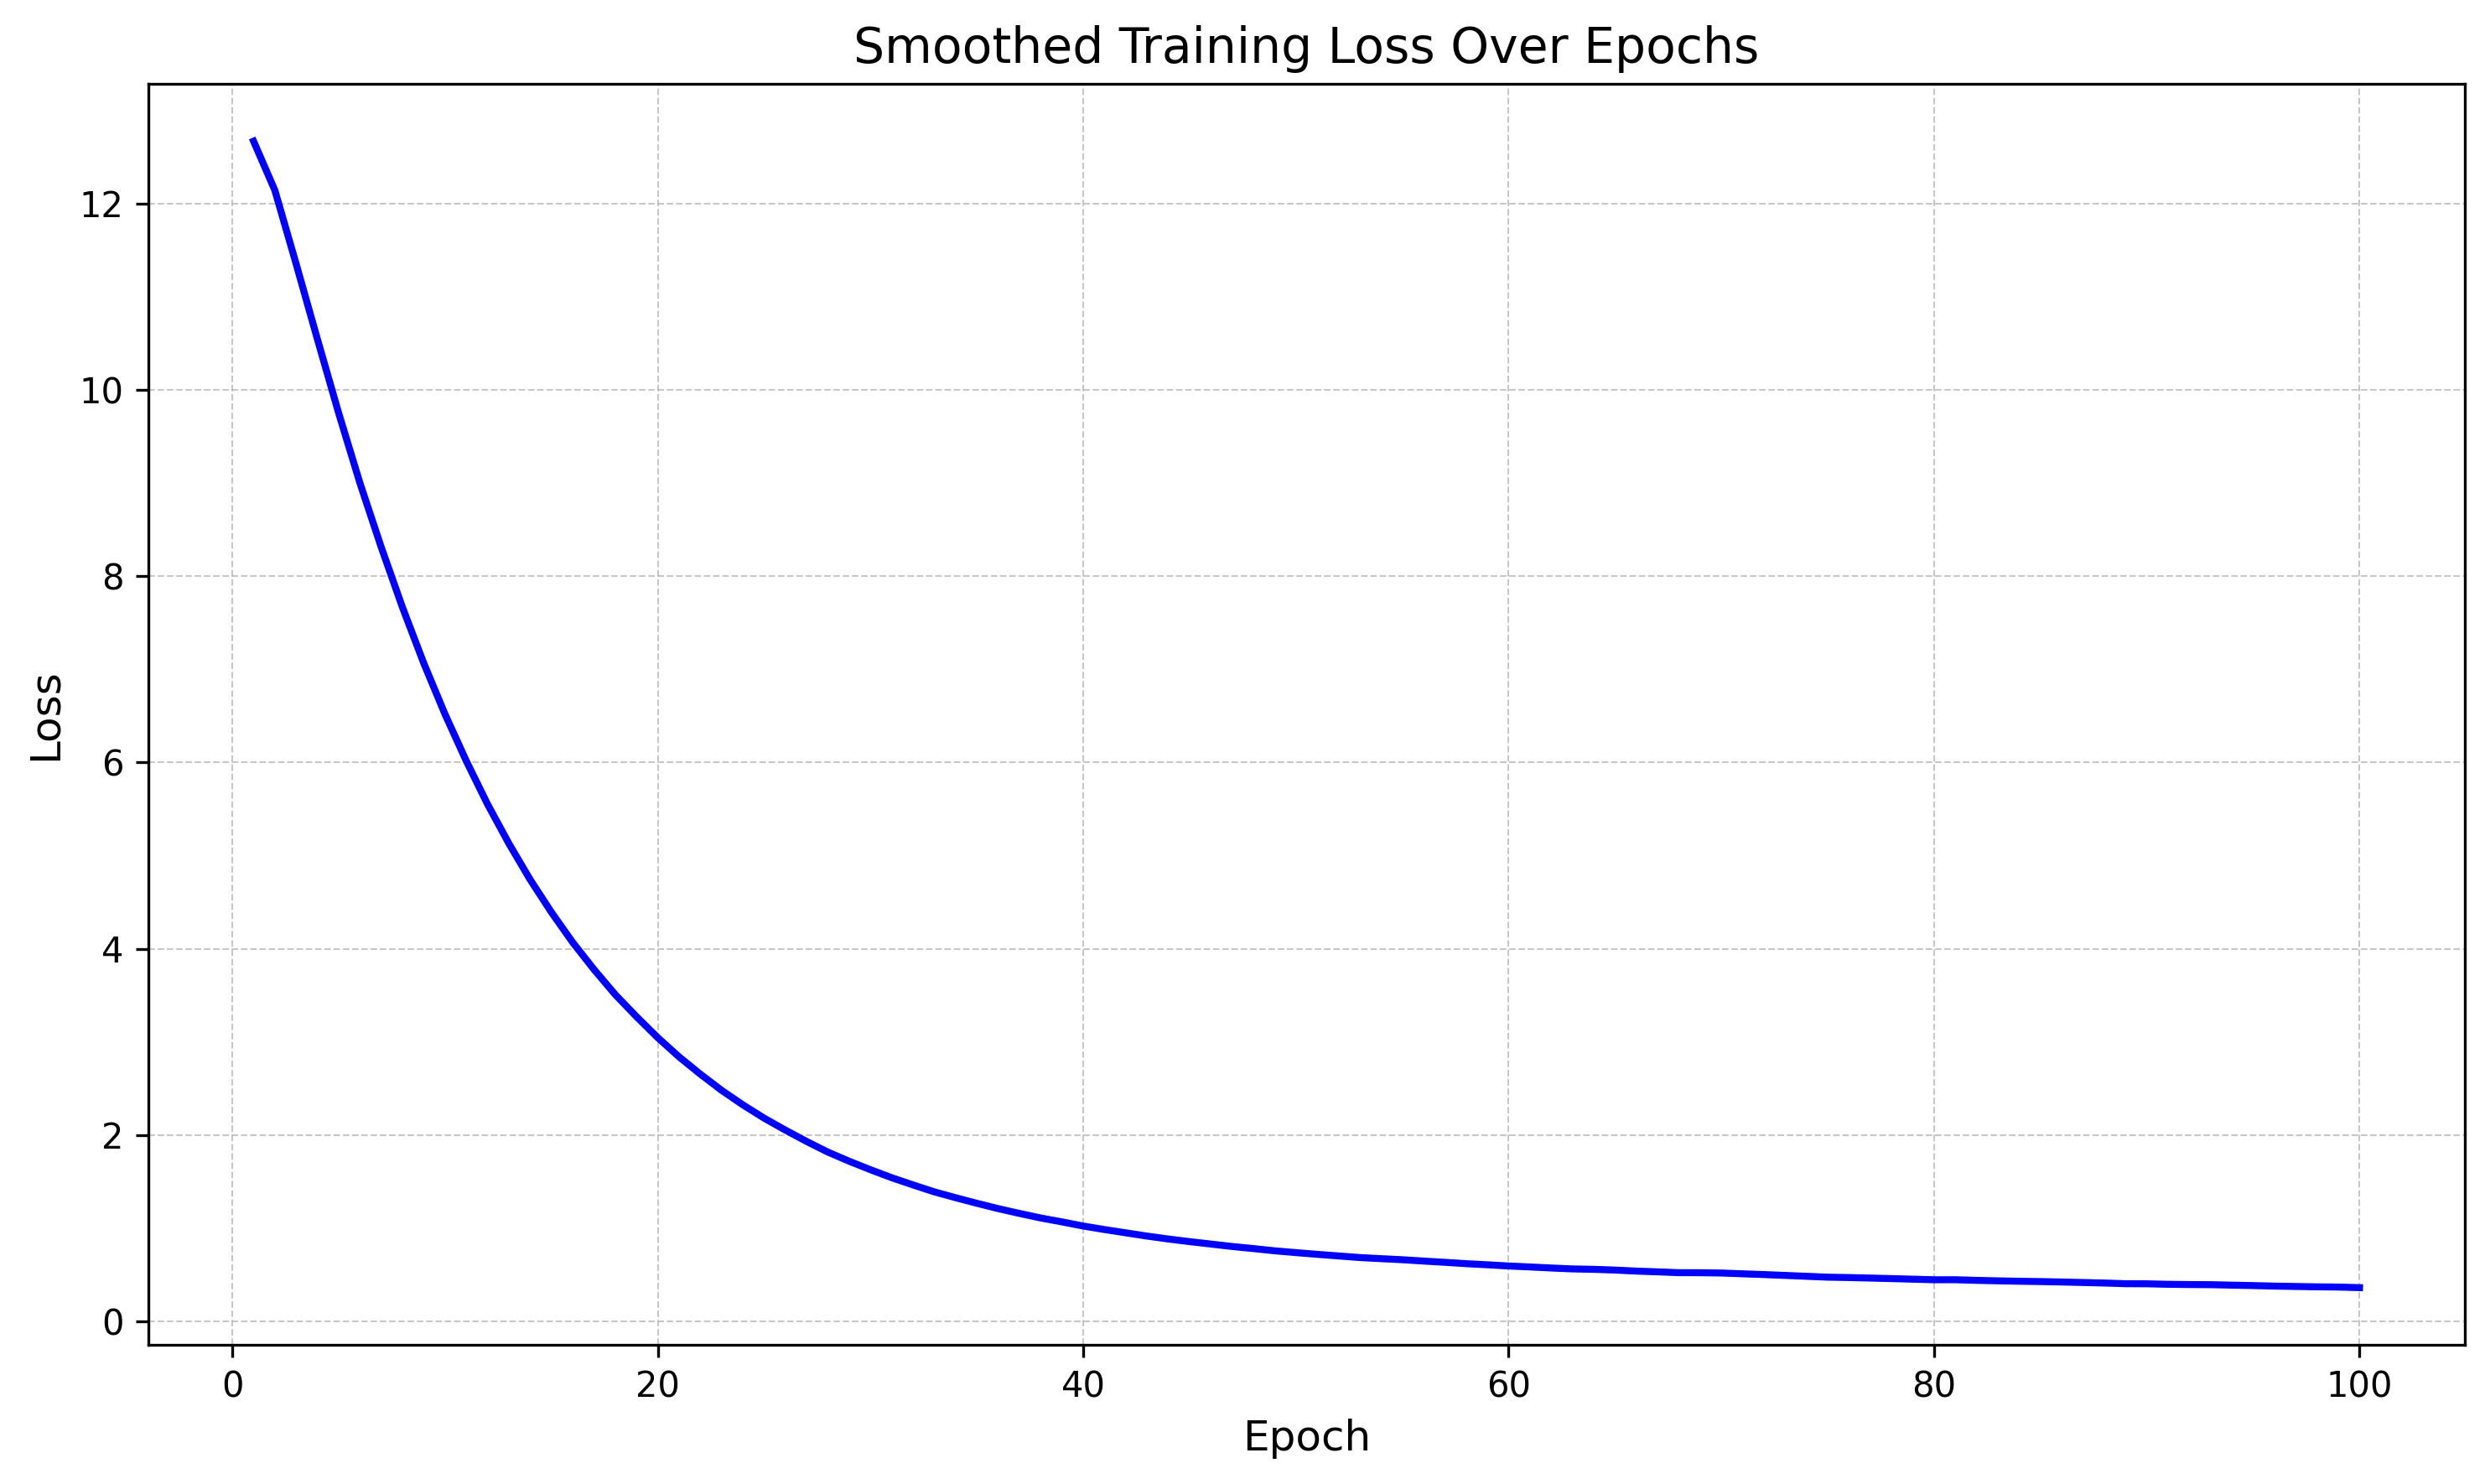

In [16]:
def smooth_curve(points, factor=0.9):
    # applies exponential smoothing to a curve
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# extract raw loss and val_loss from history
loss = loss_ot
val_loss = None

# smooth the losses
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss) if val_loss is not None else None

# plot the smoothed losses
epochs = range(1, len(smooth_loss) + 1)
plt.figure(figsize=(10, 6), dpi=300)  # High-res
plt.plot(epochs, smooth_loss, color='blue', linewidth=2)
plt.title(r'Smoothed Training Loss Over Epochs', fontsize=14)
plt.xlabel(r'Epoch', fontsize=12)
plt.ylabel(r'Loss', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("smoothed_training_loss.png", dpi=300)
plt.show()

# Testing

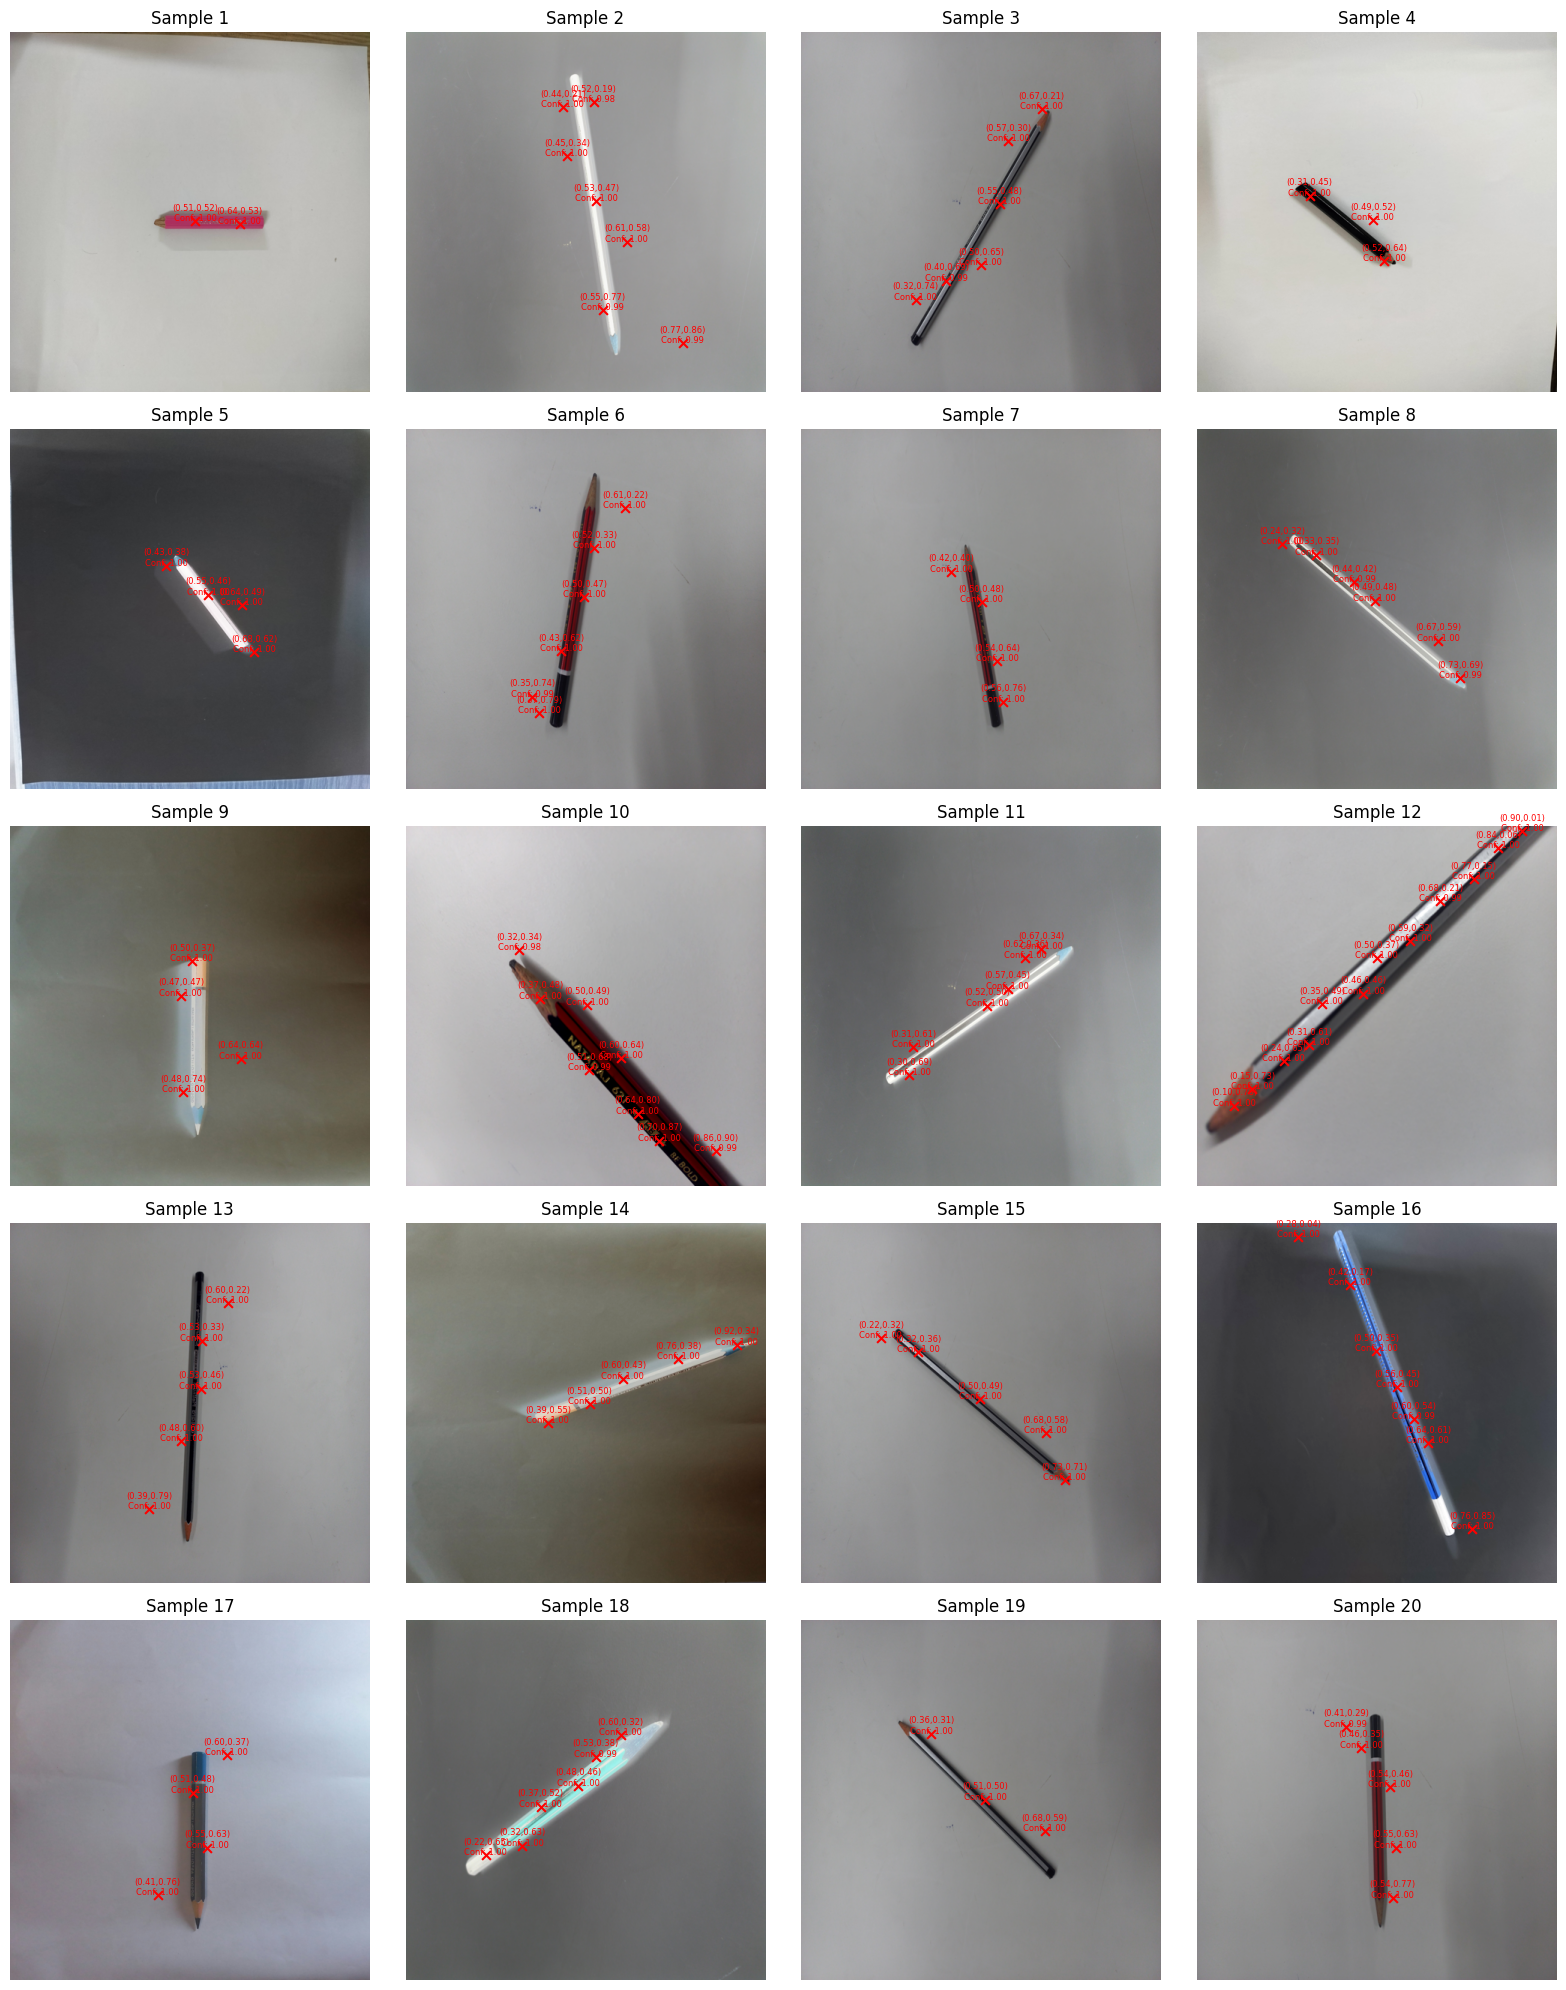

In [17]:
def visualize_predictions(model, dataloader, num_batches=20, grid_rows=5, grid_cols=4, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
    axes = axes.flatten()

    with torch.no_grad():
        batch_idx = 0
        for images, _ in dataloader:
            if batch_idx >= len(axes):
                break

            # move image to device and forward pass
            image_tensor = images[0].unsqueeze(0).to(device) # [1, H, W, C]
            image_tensor = image_tensor.permute(0, 3, 1, 2) # [1, C, H, W]
            prediction = model(image_tensor)[0].detach().cpu().numpy() # shape: [7, 7, 3]

            image_numpy = images[0].cpu().numpy() # [H, W, C]
            if image_numpy.max() <= 1.0:
                image_numpy = (image_numpy * 255).astype(np.uint8)

            img_height, img_width = image_numpy.shape[:2]

            # plotting
            ax = axes[batch_idx]
            ax.imshow(image_numpy)
            ax.set_title(f"Sample {batch_idx + 1}")
            ax.axis('off')

            x_coords, y_coords = [], []

            for row in range(7):
                for col in range(7):
                    x, y, obj = prediction[row, col]
                    if obj > 0.7:
                        x_coord = x * img_width
                        y_coord = y * img_height
                        ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                        ax.text(
                            x_coord, y_coord,
                            f"({x:.2f},{y:.2f})\nConf: {obj:.2f}",
                            fontsize=6, color='red', ha='center'
                        )
                        x_coords.append(x_coord)
                        y_coords.append(y_coord)

            batch_idx += 1

    # hide unused subplots
    for i in range(batch_idx, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("test_results.png", dpi=300)
    plt.show()

visualize_predictions(model, train_loader)

# Visualizing What the Model Sees

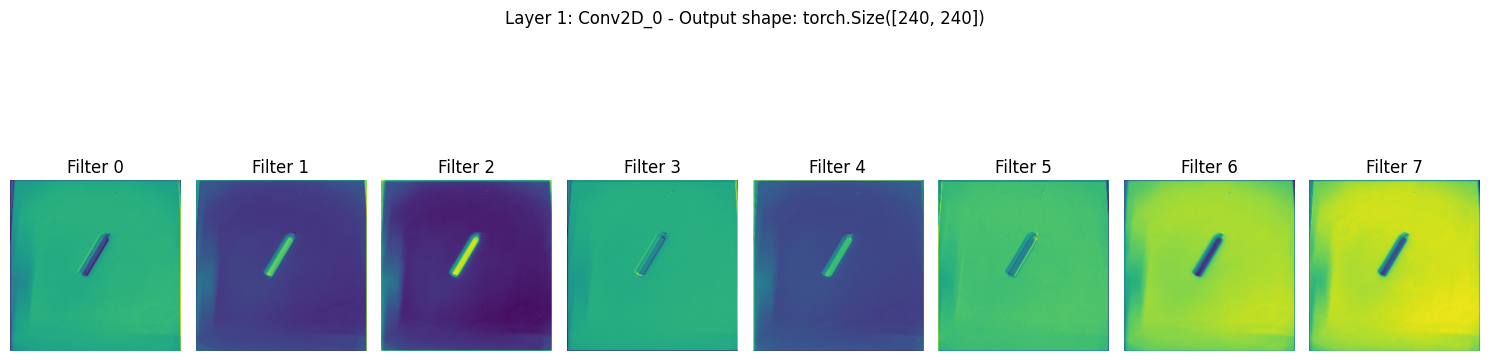

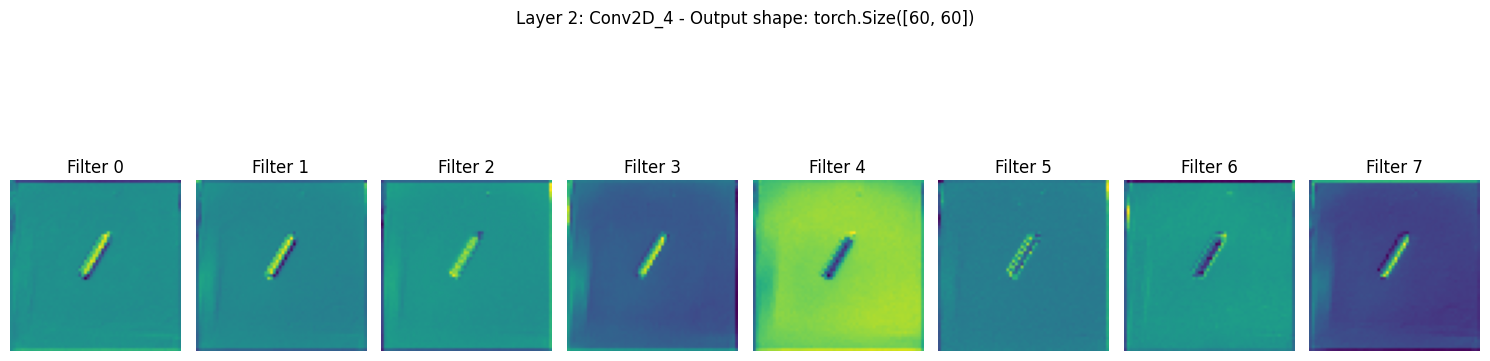

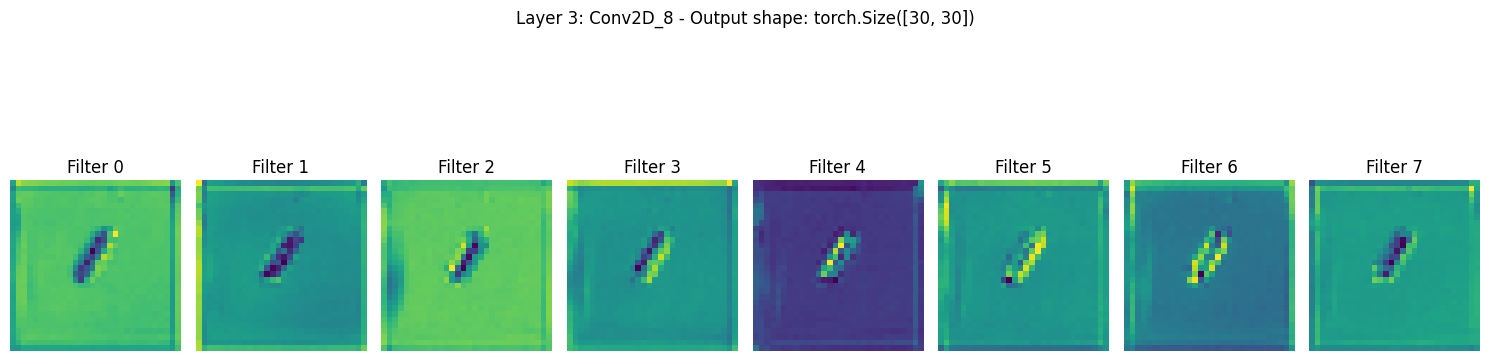

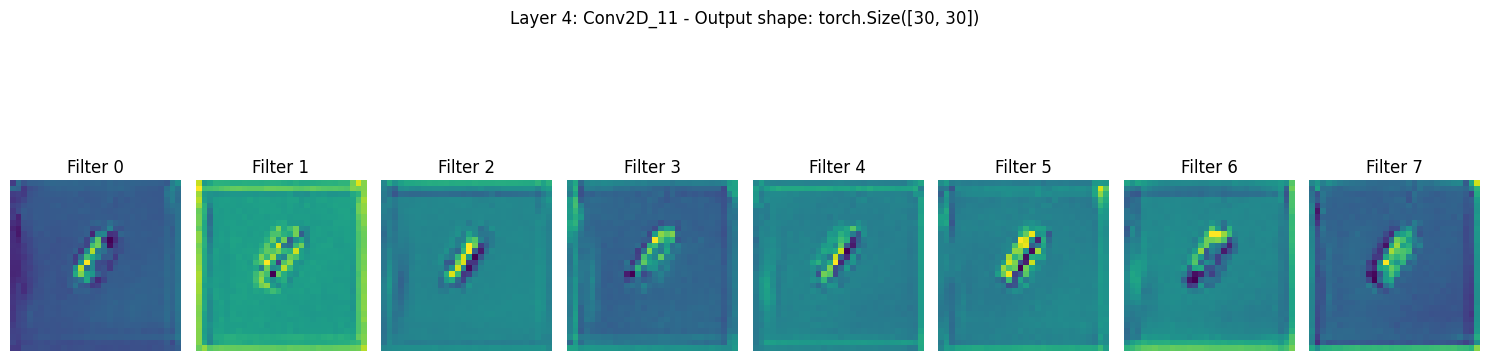

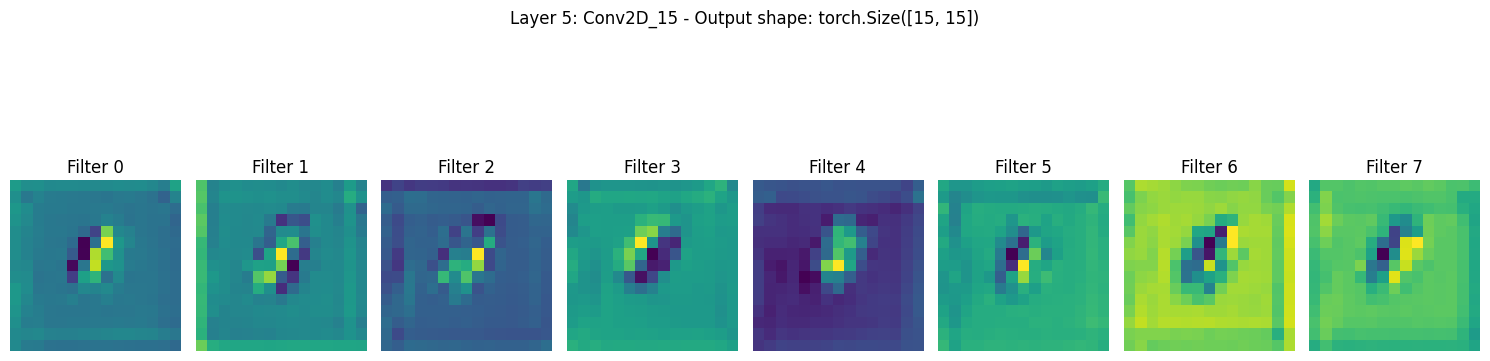

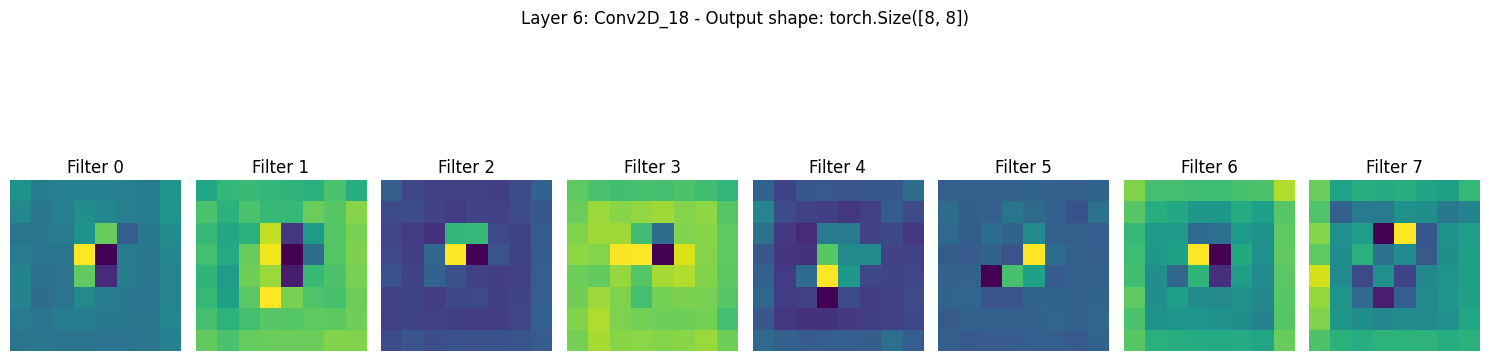

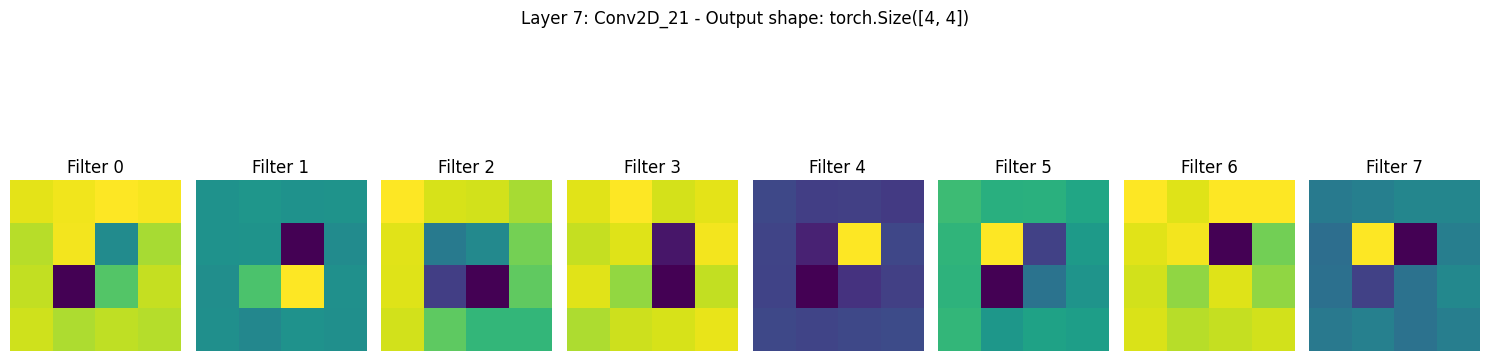

In [26]:
# list of indeces of Conv2D layers in model
conv_indices = [0, 4, 8, 11, 15, 18, 21]

# get a single batch from the dataloader
for batch_idx, (images, labels) in enumerate(dataloader):
    if batch_idx == 0:  # take first batch
        # take only the first image in the batch
        image_tensor = images[0].to(device).permute(2, 0, 1).unsqueeze(0) # [1, C, H, W]
        break

# extract only the feature extractor layers
model.eval()
feature_extractor_and_dense = list(model.children())
feature_extractor = feature_extractor_and_dense[0]
feature_extractor_layers = list(feature_extractor.children())

# visualize conv layer outputs
for i, idx in enumerate(conv_indices):
    x = image_tensor.clone()
    for layer in feature_extractor_layers[0][:idx + 1]:
        x = layer(x)

    feature_maps = x.detach().cpu().squeeze(0) # [C, H, W]
    n_filters = min(8, feature_maps.shape[0])

    fig, axs = plt.subplots(1, n_filters, figsize=(15, 5))
    fig.suptitle(f"Layer {i+1}: Conv2D_{idx} - Output shape: {feature_maps.shape[1:]}")

    for j in range(n_filters):
        axs[j].imshow(feature_maps[j].numpy(), cmap='viridis')
        axs[j].axis('off')
        axs[j].set_title(f"Filter {j}")

    plt.tight_layout()
    plt.show()

# Evaluation (Correlation Error)

In [41]:
# function that calculates the pearson correlation coefficient given a list of points
def pearson_corr(points):
    points_array = np.array(points)

    x = points_array[:, 0]
    y = points_array[:, 1]

    corr = np.corrcoef(x, y)[0, 1]
    return corr

# function that calculates the mCP value mentioned in the paper
def find_mCP(model, dataloader, threshold=0.9, num_batches=100):
    correlations = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            images_tensor = images.permute(0, 3, 1, 2).to(device)

            predictions_batch = model(images_tensor)
            batch_size = images_tensor.shape[0]

            for i in range(batch_size):
                prediction = predictions_batch[i]
                prediction = prediction.cpu().numpy()

                label = labels[i]

                # extract predicted points
                predicted_points = []
                for row in prediction:
                    for cell in row:
                        if cell[-1] > threshold:
                            predicted_points.append(list(cell[:2]))

                # extract label points
                label_points = []
                for row in label:
                    for cell in row:
                        if cell[-1] > 0:
                            label_points.append(list(cell[:2]))

                correlations.append(abs(pearson_corr(label_points + predicted_points)))

    return np.mean(correlations) if correlations else 0.0

mCP = find_mCP(model, test_loader, num_batches=100)
print("Mean Correlation Precision:", mCP * 100, "%")

Mean Correlation Precision: 87.51507176309636 %


# Finding Classification Recall, Precision and F1 Score

In [37]:
def find_recall_precision_f1_score(model, dataloader, threshold=0.9, num_batches=100):
    model.eval()
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            
            # ensure images are [batch (B), C, H, W] on the correct device
            images_tensor = images.permute(0, 3, 1, 2).float().to(device)
            
            predictions_batch = model(images_tensor) # [B, 7, 7, 3]
            batch_size = images_tensor.shape[0]
            
            for i in range(batch_size):
                prediction = predictions_batch[i]
                prediction = prediction.cpu().numpy()
                
                label = labels[i]
                label_numpy = label.cpu().numpy()
                
                # compare predictions vs labels
                for j in range(7):
                    for k in range(7):
                        pred_obj = prediction[j, k, -1]
                        label_obj = label_numpy[j, k, -1]
                        
                        if pred_obj > threshold and label_obj > 0:
                            true_positives += 1
                        elif pred_obj > threshold and label_obj == 0:
                            false_positives += 1
                        elif pred_obj <= threshold and label_obj > 0:
                            false_negatives += 1
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return recall, precision, f1_score

recall, precision, f1 = find_recall_precision_f1_score(model, test_loader, num_batches=100)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

Recall: 0.8611111111111112
Precision: 0.96875
F1 Score: 0.911764705882353


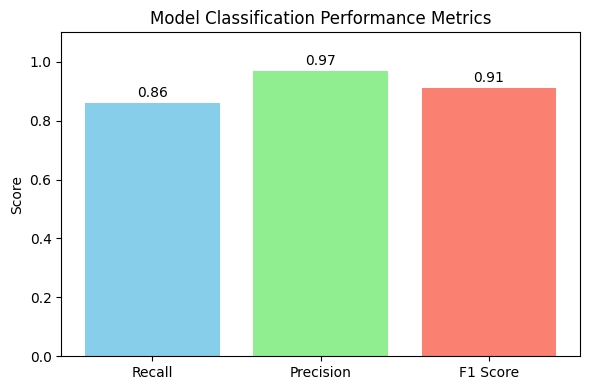

In [22]:
metrics = ['Recall', 'Precision', 'F1 Score']
values = [recall, precision, f1]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1.1)
plt.title('Model Classification Performance Metrics')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.savefig("recall-precision-f1score.png", dpi=300)
plt.show()